<a href="https://colab.research.google.com/github/GFDRR/rdl-pyTools/blob/main/ss-fl-pop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook includes a simple demo for flood risk assessment

## It uses flood hazard water depth scenario RP100 and population map for 2018

In [1]:
# Added to requirements.txt, but need to specify version? Then remove here
!pip -q install geopandas
!apt -q install libspatialindex-dev
!pip -q install osmnx
!pip -q install rasterio
!pip -q install rasterstats
!pip -q install geojson
!pip -q install contextily

Reading package lists...
Building dependency tree...
Reading state information...
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [2]:
failure = !cd rdl-pytools && git pull origin main
if "No such file or directory" in failure[0]:
  print("Cloning repo")
  !git clone https://github.com/gfdrr/rdl-pytools.git

### Import required libraries

In [3]:
# Required libraries
import tempfile

import numpy as np
import pandas as pd
import geopandas as gpd

import rasterio
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.plot import show

from rasterstats import zonal_stats, utils

# import gdal, gdalconst
# from osgeo import ogr, osr
# from shapely import wkb
# from matplotlib import pyplot
# from shapely.geometry import shape
import contextily as ctx

import matplotlib.pyplot as plt
%matplotlib inline




In [189]:
# Helper functions to perform analysis

def collect_stats(profile, shp, target_data, stats, colname):
  """
  Parameters
  ----------
  profile : rasterio profile metadata
  shp : shapefile used to select spatial area
  target_data : np.ndarray, of data
  stats : str or List[str], collection of statistics to calculate
  colname : str, target column in `shp`
  """
  # Write flood population raster to temporary file
  temp = tempfile.NamedTemporaryFile(suffix=".tiff")

  with rasterio.Env():
    with rasterio.open(temp.name, 'w', **profile) as dst:
      dst.write(target_data.astype(rasterio.int32), 1)

    # Perform zonal statistics on temporary file using the ADM2 shapefile
    shp_data = gpd.read_file(shp)
    result = {}
    for geom in shp_data.itertuples():
      result[getattr(geom, colname)] = zonal_stats(geom.geometry,
                                                   temp.name,
                                                   stats=stats)
    
    return result


def convert_stats_to_df(data, col_name, stat_name):
  """
  data : result from `collect_stats()`
  col_name : str, desired name of column in DataFrame
  stat_name : str, name of statistic used in `collect_stats()`
  """
  tmp = {k: v[0][stat_name] for (k, v) in data.items()}
  res = pd.DataFrame.from_dict(tmp, orient='index', columns=[col_name])
  return res


def plot_affected_area(df, col, title=None, ax=None, cmap='RdYlGn_r', **kwargs):
  """
  Parameters
  ----------
  df : GeoPandas DataFrame
  col : str, target column, set to None to override
  ax : matplotlib axis object to add to (optional)
  cmap : Colormap to use (default: RdYlGn_r), set to None to clear.
  kwargs : additional keyword arguments to pass into df.plot()

  Returns
  -------
  matplotlib axes object
  """
  ax = df.plot(column=col, cmap=cmap, edgecolor='k', linewidth=1, 
               figsize=(10, 10), ax=ax, **kwargs)
  ctx.add_basemap(ax, crs=df.crs.to_string())
  if title:
    ax.set_title(title, fontsize=20)

  return ax

### Load input data: flood hazard (RP100) and population (Landscan 2018)

All data already share the same crs (epsg 4326)

In [196]:
base_loc = "rdl-pytools/data/ssudan/"

#pop represents population data
with rasterio.open(base_loc+'exp-ss-pop-landscan18.tif') as fp:
  pop_data = fp.read(1)

  # Get cell size for count of affected area later on
  pop_transform = fp.transform
  pixelSizeX = pop_transform[0]
  pixelSizeY =-pop_transform[4]


scale_factor = 0.1
with rasterio.open(base_loc+'hzd-ss-fl-rp100.tif') as dataset:
  # resample data to population data resolution
  data = dataset.read(
      out_shape=(
          dataset.count,
          int(fp.height),
          int(fp.width),
      ),
      resampling=Resampling.bilinear  # Careful how the resampling is done...
  )  

  # scale image transform
  flood_transform = dataset.transform * dataset.transform.scale(
      (dataset.width / pop_data.shape[-1]),
      (dataset.height / pop_data.shape[-2])
  )

  # Create profile for later file saving
  flood_profile = dataset.profile
  flood_profile.update(
      dtype=rasterio.int32,
      count=1,
      compress='lzw',
      transform=dataset.transform
  )

flood_data = data[0, :, :]


In [184]:
# example = rasterio.open(base_loc+'hzd-ss-fl-rp100.tif')
# example.crs.to_string()  # get CRS
# example.bounds  # get bounds

In [185]:
pixelSizeX, pixelSizeY

(0.008333333333333333, 0.008333333333333333)

In [113]:
# Flood resolution and population data resolution should match
flood_data.shape == pop_data.shape

True

In [114]:
flood_data.shape

(1050, 1416)

In [115]:
#adm represents administrative units
adm0 = gpd.read_file(base_loc+'SS_ADM0.shp')
adm1 = gpd.read_file(base_loc+'SS_ADM1.shp')
adm2 = gpd.read_file(base_loc+'SS_ADM2.shp')

Check if data are loaded correctly

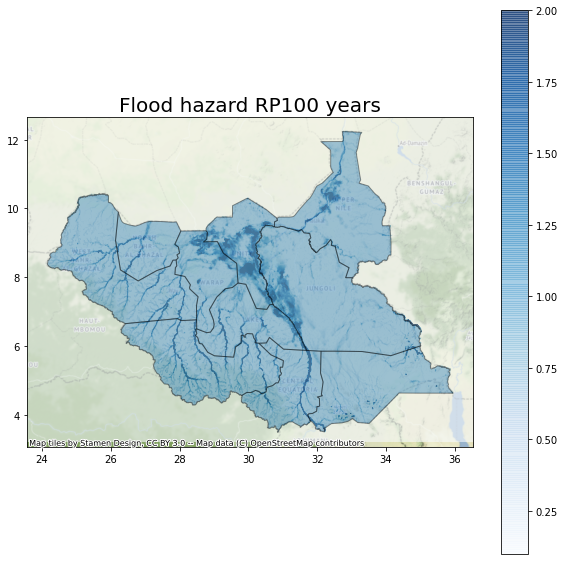

In [190]:
ax = plot_affected_area(adm1, col=None, title='Flood hazard RP100 years', alpha=0.4, cmap=None)
ax = show(flood_data, ax=ax, alpha=0.6, transform=flood_transform, 
     cmap='Blues', vmin=0.1, vmax=2);

fig = plt.gcf()
fig.colorbar(ax.images[1], ax=ax);

## 1. Flooded area

Count the number of flood cells within an ADM area 

In [121]:
adm1_flooded_areas = collect_stats(flood_profile, base_loc+'SS_ADM1.shp', flood_data, ["count"], 'ADM1_PCODE')

In [122]:
adm1_flooded_areas

{'SS01': [{'count': 415070}],
 'SS02': [{'count': 275834}],
 'SS03': [{'count': 1414294}],
 'SS04': [{'count': 730422}],
 'SS05': [{'count': 254652}],
 'SS06': [{'count': 1580880}],
 'SS07': [{'count': 623782}],
 'SS08': [{'count': 824721}],
 'SS09': [{'count': 753894}],
 'SS10': [{'count': 1038183}]}

In [123]:
flooded_area_df = convert_stats_to_df(adm1_flooded_areas, 'flooded_area', 'count')

# Convert count of cells into expected spatial resolution in degrees
flooded_area_df['flooded_area'] *= pixelSizeX*pixelSizeY

In [124]:
flooded_area_df

,flooded_area
SS01,28.824306
SS02,19.155139
SS03,98.214861
SS04,50.723750
SS05,17.684167
SS06,109.783333
SS07,43.318194
SS08,57.272292
SS09,52.353750
SS10,72.096042


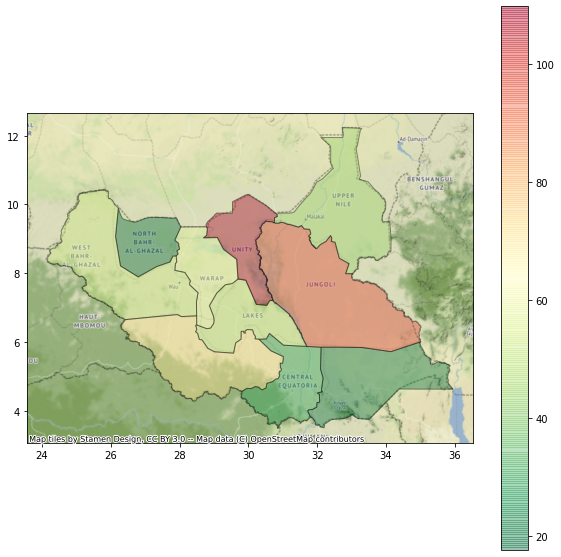

In [191]:
flooded_area_deg = adm1.join(flooded_area_df, on='ADM1_PCODE')

ax = plot_affected_area(flooded_area_deg, 'flooded_area', alpha=0.4);

fig = plt.gcf()
fig.colorbar(ax.collections[0], ax=ax);

## 2. Flooded population

Set an hazard threshold and measure the number of population within hazard extent, then summarise at ADM level.

### Create flood hazard extent mask using a threshold of 15 cm

In [192]:
# Get flooded areas
flood_mask = np.where(flood_data > 0.15, 1, 0)

In [193]:
# Flood mask should match population data resolution
flood_mask.shape == pop_data.shape

True

In [194]:
masked_pop = np.ma.masked_where(pop_data == 0, pop_data)

Show population distribution

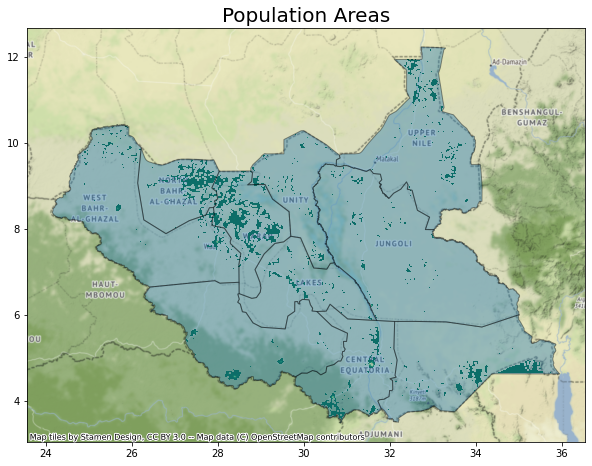

In [195]:
ax = plot_affected_area(adm1, col=None, title='Population Areas', cmap=None, alpha=0.4)
ax = show(masked_pop, ax=ax, transform=pop_transform, cmap="RdYlGn_r");
ax = show(flood_data, ax=ax, alpha=0.6, transform=flood_transform, 
     cmap='Blues', vmin=0.1, vmax=2);

### Estimate population within hazard extent and plot as map

In [128]:
pop_fd = flood_mask * pop_data

Summary for ADM1 level - zonal statistics

In [129]:
adm1_stats = collect_stats(flood_profile, base_loc+'SS_ADM1.shp', pop_fd, stats="sum", colname='ADM1_PCODE')

In [130]:
res_df1 = convert_stats_to_df(adm1_stats, 'population_sum', 'sum')

In [131]:
res_df1

,population_sum
SS01,127898080.0
SS02,103867391.0
SS03,404451153.0
SS04,16202865.0
SS05,3713715.0
SS06,16587596.0
SS07,97421794.0
SS08,2525839.0
SS09,12752387.0
SS10,49035478.0


In [132]:
pop_flood_adm1 = adm1.join(res_df1, on='ADM1_PCODE')

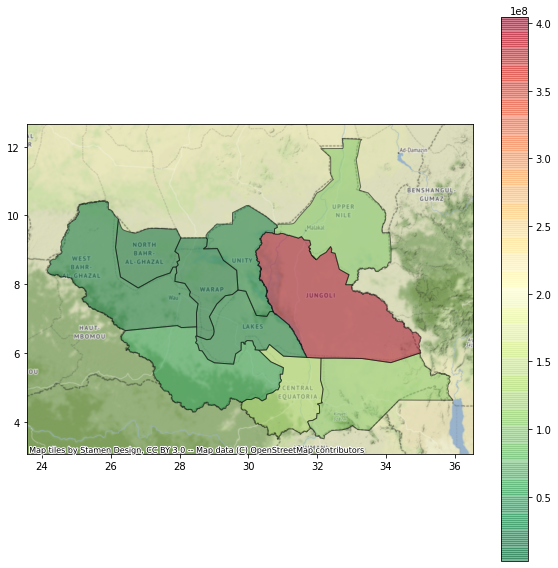

In [154]:
ax = plot_affected_area(pop_flood_adm1, 'population_sum');

fig = plt.gcf()
fig.colorbar(ax.collections[0], ax=ax);

Summary for ADM2 level - zonal statistics

In [88]:
adm2_stats = collect_stats(flood_profile, base_loc+'SS_ADM2.shp', pop_fd, stats="sum", colname='ADM2_PCODE')

In [ ]:
res_df2 = convert_stats_to_df(adm2_stats, 'population_sum', 'sum')

In [ ]:
res_df2

,population_sum
SS0101,112737054.0
SS0102,8452399.0
SS0103,227615.0
SS0104,NaN
SS0105,6481012.0
...,...
SS1006,1729013.0
SS1007,1522034.0
SS1008,20766976.0
SS1009,5810698.0


In [ ]:
pop_flood_adm2 = adm2.join(res_df2, on='ADM2_PCODE')

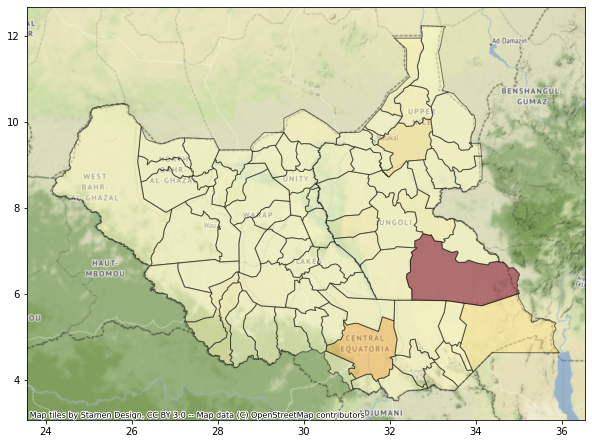

In [ ]:
ax = pop_flood_adm2.plot(column='population_sum', alpha=0.5, cmap='YlOrRd', edgecolor='k', linewidth=1, figsize=(10, 10))
ctx.add_basemap(ax, crs=pop_flood_adm2.crs.to_string())

### Export output

In [ ]:
pop_flood_adm1.to_csv("pop_flood_adm1.csv")
pop_flood_adm2.to_csv("pop_flood_adm2.csv")
pop_flood_adm1.to_file("pop_flood_adm1.shp")
pop_flood_adm2.to_file("pop_flood_adm2.shp")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  after removing the cwd from sys.path.


In [ ]:
# Download files using the menu on left-hand side